In [12]:
# Cell: Imports robustos y comprobación de dependencias
import sys
import traceback

# Función helper para avisar de imports faltantes
def _check_import(name, install_hint=None):
    try:
        module = __import__(name)
        return module
    except Exception as e:
        print(f"⚠ No se pudo importar '{name}': {e.__class__.__name__}: {e}")
        if install_hint:
            print(f"    → Instala con: {install_hint}")
        return None

# Importar paquetes principales (con mensajes claros si falta alguno)
lk = _check_import('lightkurve', "pip install lightkurve")
np = _check_import('numpy', "pip install numpy")
pd = _check_import('pandas', "pip install pandas")
plt = _check_import('matplotlib.pyplot', "pip install matplotlib")
sklearn = _check_import('sklearn', "pip install scikit-learn")
xgboost_mod = _check_import('xgboost', "pip install xgboost")
ipywidgets_mod = _check_import('ipywidgets', "pip install ipywidgets")
sns = _check_import('seaborn', "pip install seaborn")

# Si algunos imports puntuales son necesarios, importarlos de forma explícita
if plt is None:
    import matplotlib.pyplot as plt  # reintento (provoca error y lo verás)
if pd is None:
    import pandas as pd

# Importaciones específicas de sklearn y xgboost con manejo de errores
try:
    from sklearn import model_selection
    from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                                 mean_squared_error, roc_curve, auc, roc_auc_score,
                                 ConfusionMatrixDisplay)
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
    from sklearn.model_selection import StratifiedKFold, train_test_split
except Exception:
    print("⚠ Error importando submódulos de scikit-learn. Asegúrate de tener scikit-learn instalado.")
    traceback.print_exc()

try:
    from xgboost import XGBClassifier, DMatrix, XGBRFClassifier
    import xgboost as xgb
except Exception:
    print("⚠ Error importando xgboost. Instálalo con: pip install xgboost")
    traceback.print_exc()

# IPython / display / widgets
try:
    from IPython.display import Markdown, display, clear_output
except Exception:
    print("⚠ Error importando IPython.display")
    traceback.print_exc()

try:
    import ipywidgets as widgets
except Exception:
    print("⚠ Error importando ipywidgets. Instálalo con: pip install ipywidgets")
    traceback.print_exc()

# seaborn / estilo gráfico
try:
    import seaborn as sns
    sns.set(style="whitegrid")
except Exception:
    print("⚠ seaborn no disponible. Instala con: pip install seaborn")

# Helper para mostrar Markdown en notebook
def printmd(string):
    try:
        display(Markdown(string))
    except Exception:
        print(string)

# Activar plots en Jupyter (si estás en Jupyter)
%matplotlib inline

# Mensaje final de estado
print("✅ Imports ejecutados (revisa arriba si faltó alguna librería).")


✅ Imports ejecutados (revisa arriba si faltó alguna librería).


In [1]:
# ---------- Inserta / sustituye esta versión de build_features en tu script ----------
def build_features(
    long_csv_path, 
    outdir='./dataset', 
    id_col='kepid', 
    time_col='time', 
    value_col='flux',
    test_size=0.2, 
    random_state=42, 
    categorical_label_col='label',
    metadata_csv='./dataset/feature_real_data.csv',   # ahora por defecto busca tu metadata
    metadata_id_col='kepid', 
    categorical_encode=True, 
    numeric_impute_strategy='median'
):
    """
    Versión corregida de build_features.
    - Requiere un CSV largo con columnas (kepid, time, flux [, label]).
    - Une opcionalmente metadata desde ./dataset/metadata.csv por 'kepid'.
    """
    os.makedirs(outdir, exist_ok=True)
    print(f"Reading long CSV: {long_csv_path}")
    df_long = pd.read_csv(long_csv_path)
    required = {id_col, time_col, value_col}
    if not required.issubset(df_long.columns):
        raise ValueError(f"El CSV debe contener las columnas: {required}. Columnas encontradas: {list(df_long.columns)}")
    df_long = df_long.sort_values([id_col, time_col])

    # --- cargar metadata ---
    metadata_df = None
    if metadata_csv and os.path.exists(metadata_csv):
        print(f"Reading metadata CSV: {metadata_csv}")
        metadata_df = pd.read_csv(metadata_csv)
        if metadata_id_col not in metadata_df.columns:
            raise ValueError(f"metadata_csv debe contener columna '{metadata_id_col}'")
        if metadata_id_col != id_col:
            metadata_df = metadata_df.rename(columns={metadata_id_col: id_col})
        # convertir columnas numéricas si es posible
        for col in metadata_df.columns:
            if col != id_col:
                metadata_df[col] = pd.to_numeric(metadata_df[col], errors='ignore')
        print("Metadata columns and dtypes:")
        print(metadata_df.dtypes.head(40))

    # --- agrupar y generar features ---
    groups = df_long.groupby(id_col)
    features_list = []
    print("Computing features per id...")
    for kid, group in tqdm(groups, total=len(groups)):
        values = group[value_col].values
        feats = compute_features_for_series(values)
        meta = group.iloc[0].to_dict()
        for c in (time_col, value_col):
            meta.pop(c, None)
        meta.update({'kepid': kid})
        meta.update(feats)
        features_list.append(meta)

    features_df = pd.DataFrame(features_list).set_index('kepid', drop=False)

    # --- unir metadata ---
    if metadata_df is not None:
        metadata_df = metadata_df.drop_duplicates(subset=[id_col])
        features_df = features_df.reset_index(drop=True).set_index(id_col, drop=False)
        metadata_df = metadata_df.set_index(id_col, drop=False)
        features_df = features_df.merge(metadata_df, how='left', on='kepid', suffixes=('', '_meta'))
        features_df = features_df.set_index('kepid', drop=False)
        print(f"After merge, features shape: {features_df.shape}")

    # --- manejar label y planet ---
    if categorical_label_col in df_long.columns:
        label_map = df_long.groupby(id_col)[categorical_label_col].first()
        features_df[categorical_label_col] = features_df['kepid'].map(label_map)

    if 'label' in features_df.columns:
        features_df['planet'] = np.where(features_df['label'] == 'PC', 1, 0)

    # --- imputación y codificación ---
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = features_df.select_dtypes(include=['object','category']).columns.tolist()
    if categorical_label_col in cat_cols:
        cat_cols.remove(categorical_label_col)

    print(f"Numeric cols: {len(numeric_cols)}, Cat cols: {len(cat_cols)}")

    if numeric_impute_strategy == 'median':
        for col in numeric_cols:
            if col != 'kepid':
                med = np.nanmedian(features_df[col].values.astype(float))
                features_df[col] = features_df[col].fillna(med)
    elif numeric_impute_strategy == 'mean':
        for col in numeric_cols:
            if col != 'kepid':
                meanv = np.nanmean(features_df[col].values.astype(float))
                features_df[col] = features_df[col].fillna(meanv)

    if categorical_encode and len(cat_cols) > 0:
        for col in cat_cols:
            nunique = features_df[col].nunique(dropna=True)
            if nunique <= 10:
                dummies = pd.get_dummies(features_df[col].astype(str), prefix=col, dummy_na=True)
                features_df = pd.concat([features_df, dummies], axis=1)
                features_df.drop(columns=[col], inplace=True)
            else:
                features_df[col] = features_df[col].astype('category').cat.codes

    # --- split train/test ---
    if 'label' in features_df.columns and features_df['label'].notna().any():
        train_df, test_df = train_test_split(features_df, test_size=test_size, stratify=features_df['label'], random_state=random_state)
    else:
        train_df, test_df = train_test_split(features_df, test_size=test_size, random_state=random_state)

    # --- persist ---
    features_path = os.path.join(outdir, 'features_real_data.pkl')
    features_test_path = os.path.join(outdir, 'features_real_test_data.pkl')
    train_path = os.path.join(outdir, 'train_data.pkl')
    test_path = os.path.join(outdir, 'test_data.pkl')
    print(f"Saving features -> {features_path} ({features_df.shape})")
    features_df.to_pickle(features_path)
    print(f"Saving features test -> {features_test_path} ({test_df.shape})")
    test_df.to_pickle(features_test_path)
    print(f"Saving train/test pickles -> {train_path}, {test_path}")
    train_df.to_pickle(train_path)
    test_df.to_pickle(test_path)
    print("Done.")
    return features_df, train_df, test_df
# ---------- fin de la función modificada ----------


In [21]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def csv_to_pkls(csv_path, outdir=None, test_size=0.2, random_state=42, label_col="label", sep=','):
    """
    Convierte un único CSV de features a los 4 PKL:
    - features_real_data.pkl
    - features_real_test_data.pkl
    - train_data.pkl
    - test_data.pkl

    Maneja filas con errores automáticamente y permite definir el separador.
    """
    # Carpeta de salida
    if outdir is None:
        outdir = os.path.dirname(csv_path)
    os.makedirs(outdir, exist_ok=True)

    print(f"Reading features CSV: {csv_path}")
    
    # Leer CSV tolerante a errores
    try:
        df = pd.read_csv(csv_path, sep=sep, engine='python', on_bad_lines='skip')
    except Exception as e:
        print("Error leyendo el CSV:", e)
        return None, None, None

    print(f"CSV loaded. Shape after skipping bad lines: {df.shape}")

    # Split estratificado si hay label
    if label_col in df.columns and df[label_col].notna().any():
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            stratify=df[label_col],
            random_state=random_state
        )
    else:
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Paths de salida
    features_path = os.path.join(outdir, 'features_real_data.pkl')
    features_test_path = os.path.join(outdir, 'features_real_test_data.pkl')
    train_path = os.path.join(outdir, 'train_data.pkl')
    test_path = os.path.join(outdir, 'test_data.pkl')

    # Guardar PKL
    print(f"Saving features -> {features_path} ({df.shape})")
    df.to_pickle(features_path)

    print(f"Saving features test -> {features_test_path} ({test_df.shape})")
    test_df.to_pickle(features_test_path)

    print(f"Saving train/test pickles -> {train_path}, {test_path}")
    train_df.to_pickle(train_path)
    test_df.to_pickle(test_path)

    # Imprimir rutas absolutas para confirmar
    print("\nFiles created:")
    for f in [features_path, features_test_path, train_path, test_path]:
        print(os.path.abspath(f), "| exists:", os.path.exists(f))

    print("Done.")
    return df, train_df, test_df


# --- Uso con tu ruta ---
csv_to_pkls(
    r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\features_real_data.csv",
    outdir=r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset"
)


Reading features CSV: C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\features_real_data.csv
CSV loaded. Shape after skipping bad lines: (143, 1)
Saving features -> C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\features_real_data.pkl ((143, 1))
Saving features test -> C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\features_real_test_data.pkl ((29, 1))
Saving train/test pickles -> C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\train_data.pkl, C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\test_data.pkl

Files created:
C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\features_real_data.pkl | exists: True
C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\features_real_test_data.pkl | exists: True
C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset\train_data.pkl | exists: True
C:\Users\aquil\OneDrive\Documents

(    # This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
 0                           # Sat Oct  4 17:44:57 2025                                              
 1                                                    #                                              
 2                       # COLUMN kepid:          KepID                                              
 3                    # COLUMN kepoi_name:     KOI Name                                              
 4                 # COLUMN kepler_name:    Kepler Name                                              
 ..                                                 ...                                              
 138  # COLUMN koi_dikco_mdec: PRF &Delta;&delta;<su...                                              
 139  # COLUMN koi_dikco_mdec_err: PRF &Delta;&delta...                                              
 140  # COLUMN koi_dikco_msky: PRF &Delta;&theta;<su...                           

# Data loading and preprocessing

In [23]:
import os
import numpy as np
import pandas as pd

dataset_dir = r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset"

# Rutas absolutas
features_path = os.path.join(dataset_dir, 'features_real_data.pkl')
features_test_path = os.path.join(dataset_dir, 'features_real_test_data.pkl')
train_path = os.path.join(dataset_dir, 'train_data.pkl')
test_path = os.path.join(dataset_dir, 'test_data.pkl')

# Leer datos
data = pd.read_pickle(features_path)
data_test = pd.read_pickle(features_test_path)
orig_data = pd.concat([pd.read_pickle(train_path), pd.read_pickle(test_path)], ignore_index=True)

# Verificar columnas
print("Columns in data:", data.columns)

# Ajustar según nombre de columna real
label_col = 'label'   # cambia por 'label_meta' si ese es el nombre real
if label_col in data.columns:
    data['planet'] = np.where(data[label_col] == 'PC', 1, 0)
    data_test['planet'] = np.where(data_test[label_col] == 'PC', 1, 0)
else:
    print(f"Warning: columna '{label_col}' no encontrada en data. Planet column no se creó.")

# Información
print("Features data shape:", data.shape)
print("Test features shape:", data_test.shape)
print("Original combined data shape:", orig_data.shape)
data.head()


Columns in data: Index(['# This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu'], dtype='object')
Features data shape: (143, 1)
Test features shape: (29, 1)
Original combined data shape: (143, 1)


,# This file was produced by the NASA Exoplanet Archive http://exoplanetarchive.ipac.caltech.edu
0,# Sat Oct 4 17:44:57 2025
1,#
2,# COLUMN kepid: KepID
3,# COLUMN kepoi_name: KOI Name
4,# COLUMN kepler_name: Kepler Name


In [26]:
data = pd.concat([data, data_test], ignore_index=True)

In [29]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler

dataset_dir = r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset"
csv_path = os.path.join(dataset_dir, 'features_real_data.csv')

# Leer CSV ignorando comentarios
data = pd.read_csv(csv_path, sep=',', comment='#')  # cambia sep si es necesario

print("Columns loaded:", data.columns)

# Crear columna planet si existe 'label' o 'label_meta'
label_col_candidates = ['label', 'label_meta']
label_col = next((col for col in label_col_candidates if col in data.columns), None)

if label_col is None:
    print("No se encontró columna 'label'. Revisa tu CSV.")
else:
    data['planet'] = np.where(data[label_col] == 'PC', 1, 0)
    print("Column 'planet' creada correctamente.")

# Ahora puedes continuar con tu procesamiento


Columns loaded: Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score',
       'koi_fpflag_nt',
       ...
       'koi_dicco_mdec', 'koi_dicco_mdec_err', 'koi_dicco_msky',
       'koi_dicco_msky_err', 'koi_dikco_mra', 'koi_dikco_mra_err',
       'koi_dikco_mdec', 'koi_dikco_mdec_err', 'koi_dikco_msky',
       'koi_dikco_msky_err'],
      dtype='object', length=141)
No se encontró columna 'label'. Revisa tu CSV.


In [37]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn import model_selection

# Ruta de tu dataset
dataset_dir = r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset"
csv_path = os.path.join(dataset_dir, 'features_real_data.csv')

# 1) Leer CSV (ignorar comentarios de NASA)
data = pd.read_csv(csv_path, sep=',', comment='#')
print("Columns loaded:", data.columns.tolist())
print("Sample rows:\n", data.head())

# 2) Detectar columna de labels (si no existe) buscando valores típicos
label_values = {"PC", "CANDIDATE", "CONFIRMED", "FALSE POSITIVE", "FP", "AFP"}
label_col = None
for col in data.columns:
    # comprobar si alguno de los valores esperados aparece en la columna
    if data[col].astype(str).isin(label_values).any():
        label_col = col
        break

if label_col is None:
    # si no la detectó, mostrar resumen rápido para que decidas cuál usar
    print("\nNo se detectó columna de labels automáticamente. Valores únicos por columna (hasta 10):")
    for col in data.columns:
        print(col, "->", pd.unique(data[col].astype(str))[:10])
    raise ValueError("No se encontró columna de label con valores típicos. Indica manualmente el nombre de la columna de etiqueta.")

print(f"\nColumna de labels detectada: {label_col}")
print("Valores únicos en label:", pd.unique(data[label_col].astype(str))[:20])

# 3) Crear columna planet (1 = candidato/confirmado, 0 = resto)
positive_states = {"PC", "CANDIDATE", "CONFIRMED"} 
data['planet'] = np.where(data[label_col].astype(str).isin(positive_states), 1, 0)

# 4) Preparar X (features) y y
X = data.drop([label_col, 'planet'], axis=1, errors='ignore')  # puede contener columnas no numéricas
y = data['planet']

# 5) Intentar convertir todo a numérico (coerce -> NaN cuando no sea posible)
X_num = X.copy()
for c in X_num.columns:
    X_num[c] = pd.to_numeric(X_num[c], errors='coerce')

# 6) Detectar columnas totalmente no-numéricas (quedaron todas NaN tras coerción)
non_numeric_cols = [c for c in X_num.columns if X_num[c].isna().all()]
if non_numeric_cols:
    print("\nColumnas no numéricas (se eliminarán antes del escalado):", non_numeric_cols)

# 7) Dropear columnas no numéricas
X_num = X_num.drop(columns=non_numeric_cols)

# 8) Verificar que queden columnas numéricas
if X_num.shape[1] == 0:
    raise ValueError("No hay columnas numéricas para escalar. Revisa las columnas del CSV o convierte las categóricas a numéricas manualmente.")

print("\nColumnas numéricas para escalar:", X_num.columns.tolist())

# 9) Imputar NaNs con la mediana por columna
X_num = X_num.fillna(X_num.median())

# 10) Escalar con RobustScaler (manteniendo index)
X_scaled = pd.DataFrame(RobustScaler().fit_transform(X_num), columns=X_num.columns, index=X_num.index)

# 11) Si quieres conservar metadata no numérica (opcional), las concatenamos sin escalar:
#    Nota: conservar metadatos puede no ser útil para modelos numéricos; coméntalo si no deseas.
meta_cols = non_numeric_cols  # ya detectadas arriba
if meta_cols:
    X_final = pd.concat([X_scaled, X[meta_cols]], axis=1)
else:
    X_final = X_scaled.copy()

# 12) Reconstruir df_final y añadir etiqueta
df_final = X_final.copy()
df_final['Planet'] = y

# 13) Eliminar columnas constantes (si las hay)
df_final = df_final.loc[:, (df_final != df_final.iloc[0]).any()]

# 14) Mezclar filas para entrenamiento
seed = 12345
df_final = df_final.sample(frac=1, random_state=seed)

# 15) Etiqueta objetivo
y1 = df_final['Planet']

print("\ndf_final shape:", df_final.shape)
print("First rows:\n", df_final.head())

# 16) Ahora puedes hacer el split (ejemplo):
X_features = df_final.drop('Planet', axis=1)
X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    X_features, y1, test_size=0.25, random_state=seed, stratify=y1 if y1.nunique()>1 else None
)

print("\nSplit shapes: ", X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape)


Columns loaded: ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_ror', 'koi_ror_err1', 'koi_ror_err2', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_fittype', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'k

### Model Training

In [38]:
X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    df_final.drop(columns=['Planet']),  # todas las features
    df_final['Planet'],                # la etiqueta
    test_size=0.25,
    random_state=seed
)


In [40]:
# Mantener solo columnas numéricas
X = df_final.drop(columns=['Planet'])
X = X.select_dtypes(include=[np.number])  # quita object y string
y = df_final['Planet']

X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    X, y, test_size=0.25, random_state=seed
)


c:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:26:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy y ROC AUC: [0.9937264742785445, 0.9998117780744548]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1203
           1       0.99      0.99      0.99      1188

    accuracy                           0.99      2391
   macro avg       0.99      0.99      0.99      2391
weighted avg       0.99      0.99      0.99      2391



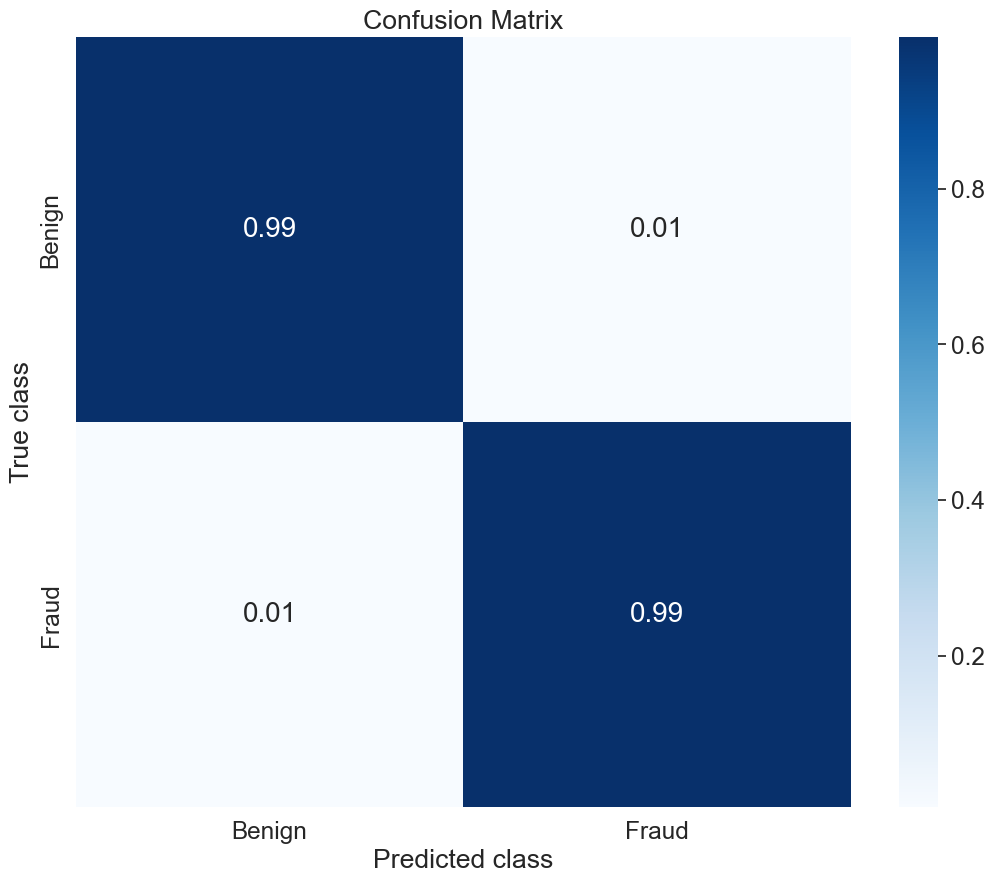

In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

# --- 1. Entrenar modelo ---
xgbc1 = XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    scale_pos_weight=3.37,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.5,
    gamma=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgbc1.fit(X1_train, y1_train)

# --- 2. Generar predicciones ---
pred1 = xgbc1.predict(X1_test)
y1_test_prob = xgbc1.predict_proba(X1_test)[:, 1]

# --- 3. Métricas ---
score1 = [accuracy_score(y1_test, pred1), roc_auc_score(y1_test, y1_test_prob)]
report1 = classification_report(y1_test, pred1)

print("Accuracy y ROC AUC:", score1)
print(report1)

# --- 4. Matriz de confusión ---
conf_matrix = confusion_matrix(y1_test, pred1)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

import matplotlib.pyplot as plt
import seaborn as sns
Labels = ["Benign","Fraud"]

plt.figure(figsize=(12.5, 10))
sns.set(font_scale=1.6)
ax = sns.heatmap(conf_matrix, xticklabels=Labels, yticklabels=Labels,
                 annot=True, annot_kws={"size": 20}, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


## LGBM Model

In [46]:
y = df_final.Planet
X = df_final.iloc[:,:-1].values
skf = StratifiedKFold(n_splits=5, shuffle = True)
skf.get_n_splits(X, y)

5

In [54]:
import pandas as pd
import numpy as np

# Ruta del CSV
dataset_dir = r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset"
csv_path = dataset_dir + r"\features_real_data.csv"

# Leer CSV ignorando comentarios
data = pd.read_csv(csv_path, sep=',', comment='#')

print("Columns loaded:", data.columns.tolist())
print(data.head())

# Detectar la columna de label real
# Por ejemplo en los CSV de la NASA suele ser 'koi_disposition'
label_col_candidates = ['koi_disposition', 'label', 'label_meta']  
label_col = next((col for col in label_col_candidates if col in data.columns), None)

if label_col is None:
    raise ValueError("No se encontró columna de labels en el CSV")

# Crear columna binaria planet
# Ajusta el valor según tu CSV, puede ser 'CANDIDATE' o 'CONFIRMED'
data['planet'] = np.where(data[label_col] == 'CANDIDATE', 1, 0)

print(f"Label column used: {label_col}")
print(data[['planet', label_col]].head())


Columns loaded: ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_ror', 'koi_ror_err1', 'koi_ror_err2', 'koi_srho', 'koi_srho_err1', 'koi_srho_err2', 'koi_fittype', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_sma', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'k

In [56]:
# Seleccionar solo columnas numéricas para XGBoost
X_numeric = df_final.drop(columns=['Planet']).select_dtypes(include=[np.number])

# Crear DataFrame para predicciones
df_pred = pd.DataFrame(index=df_final.index)
df_pred['idx'] = df_final.index
df_pred['pred'] = xgbc1.predict_proba(X_numeric)[:, 1]

# Ordenar y filtrar
df_pred = df_pred.sort_values(by='pred', ascending=False)
predicted_planets = df_pred[df_pred['pred'] > 0.5]

print(predicted_planets.head())


       idx      pred
223    223  0.999999
1913  1913  0.999999
1152  1152  0.999999
303    303  0.999999
1035  1035  0.999999


In [58]:
# Obtener booster
bst1 = xgbc1.get_booster()

# Seleccionar solo columnas numéricas
X_numeric_pred = df_final.loc[predicted_planets.idx].drop(columns=['Planet']).select_dtypes(include=[np.number])

# Crear DMatrix solo con datos numéricos
data_matrix = xgb.DMatrix(data=X_numeric_pred)

# Obtener predicciones con SHAP values
df_temp = pd.DataFrame(bst1.predict(data_matrix, pred_contribs=True))

# Quitar la última columna (bias)
df_temp = df_temp.iloc[:, :-1]

# Asignar nombres de columnas correctos
df_temp.columns = X_numeric_pred.columns
df_temp.index = predicted_planets.idx

# Concatenar SHAP values con predicciones
predicted_planets_shaps = pd.concat([predicted_planets.set_index('idx'), df_temp], axis=1)

# Casos predichos
predicted_planets_cases = df_final.loc[predicted_planets.idx]
predicted_planets_cases = pd.concat([predicted_planets[['pred']].set_index(predicted_planets.idx), predicted_planets_cases], axis=1)

print(predicted_planets_shaps.head())
print(predicted_planets_cases.head())


          pred     rowid     kepid  koi_score  koi_fpflag_nt  koi_fpflag_ss  \
idx                                                                           
223   0.999999  1.331592  0.063731   1.939930       1.237621       1.185546   
1913  0.999999  1.088578  0.118228   2.104420       1.242845       1.224167   
1152  0.999999  1.372313 -0.039974   1.950951       1.135703       1.180922   
303   0.999999  1.262711  0.054633   1.916654       1.189388       1.197345   
1035  0.999999  1.386807 -0.068685   2.033899       1.274915       1.185674   

      koi_fpflag_co  koi_fpflag_ec  koi_period  koi_period_err1  ...  \
idx                                                              ...   
223        0.822321       0.307359    0.055251        -0.012343  ...   
1913       0.818325       0.303372    0.046592         0.003553  ...   
1152       0.794752       0.263556   -0.061784        -0.008724  ...   
303        0.800121       0.260128   -0.010717        -0.007062  ...   
1035       0.8

In [59]:
## False negatives: Sorted with prob
case_interest = predicted_planets_cases[predicted_planets_cases.Planet==0]

In [60]:
## Number of possible cases missed!
case_interest.shape

(12, 136)

### Overall Results: Confusion Matrix

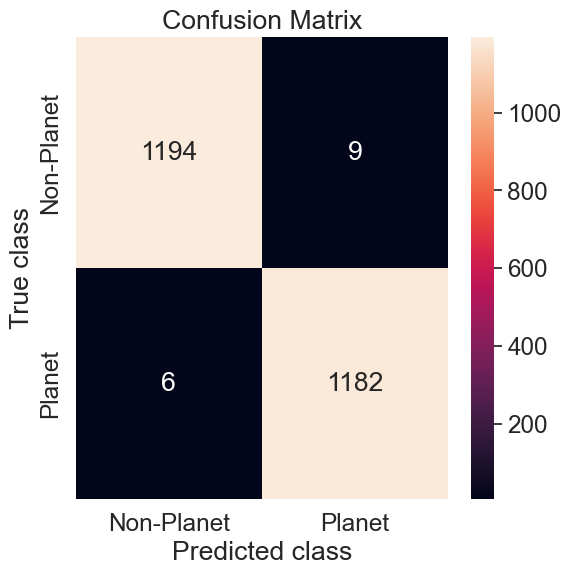

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y1_test, pred1)
Labels = ["Non-Planet","Planet"]
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [68]:
import os, json
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.preprocessing import RobustScaler

# --- Config rutas opcionales de respaldo ---
DATASET_DIR = r"C:\Users\aquil\OneDrive\Documents\Exoplanets\ExoplanetsHunters\dataset"
PKL_FALLBACK = os.path.join(DATASET_DIR, "features_real_data.pkl")
CSV_FALLBACK = os.path.join(DATASET_DIR, "features_real_data.csv")

LABEL_CANDIDATES = ["Planet", "planet", "label", "label_meta", "koi_disposition", "koi_pdisposition"]

def make_numeric_X(df: pd.DataFrame) -> pd.DataFrame:
    """Quita etiquetas conocidas, convierte a numérico (coerce) e imputa medianas.
       Elimina columnas totalmente NaN y devuelve solo numéricas."""
    df = df.copy()
    # quitar posibles etiquetas
    drop_these = [c for c in LABEL_CANDIDATES if c in df.columns]
    if drop_these:
        df = df.drop(columns=drop_these, errors="ignore")
    # convertir a numérico
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    # eliminar columnas totalmente NaN
    all_nan = [c for c in df.columns if df[c].isna().all()]
    if all_nan:
        print("🔎 Columnas eliminadas (todo NaN):", all_nan)
        df = df.drop(columns=all_nan)
    # quedarnos SOLO numéricas
    df = df.select_dtypes(include=[np.number])
    if df.shape[1] == 0:
        raise ValueError("No hay columnas numéricas válidas tras coerción.")
    # imputar por mediana
    df = df.fillna(df.median())
    return df

# 1) Intentar desde df_final (si existe)
X_train = None
if 'df_final' in locals() and isinstance(df_final, pd.DataFrame) and not df_final.empty:
    try:
        X_train = make_numeric_X(df_final)
        print("✅ X_train generado desde df_final.")
    except Exception as e:
        print("⚠️ No se pudo usar df_final:", e)

# 2) Intentar desde PKL
if X_train is None and os.path.exists(PKL_FALLBACK):
    try:
        tmp = pd.read_pickle(PKL_FALLBACK)
        X_train = make_numeric_X(tmp)
        print("✅ X_train generado desde features_real_data.pkl.")
    except Exception as e:
        print("⚠️ No se pudo usar PKL:", e)

# 3) Intentar desde CSV
if X_train is None and os.path.exists(CSV_FALLBACK):
    try:
        tmp = pd.read_csv(CSV_FALLBACK, comment="#")
        X_train = make_numeric_X(tmp)
        print("✅ X_train generado desde features_real_data.csv.")
    except Exception as e:
        print("⚠️ No se pudo usar CSV:", e)

# 4) Si aún no hay X_train -> error descriptivo
if X_train is None or X_train.shape[1] == 0:
    raise ValueError(
        "No fue posible construir X_train numérico.\n"
        "Verifica que df_final o los archivos features_real_data contengan columnas numéricas.\n"
        "Sugerencia: revisa dtypes con: print(df_final.dtypes.head(20))"
    )

# 5) Crear/ajustar scaler y guardar artefactos
if 'scaler' not in locals():
    scaler = RobustScaler().fit(X_train)

if 'xgbc1' not in locals():
    raise NameError("No se encontró el modelo 'xgbc1'. Entrénalo antes de exportar artefactos.")

os.makedirs("artifacts", exist_ok=True)

dump(xgbc1, "artifacts/model_xgb.pkl")
dump(scaler, "artifacts/scaler.joblib")

columns = list(X_train.columns)
with open("artifacts/feature_columns.json", "w", encoding="utf-8") as f:
    json.dump(columns, f)

print("🎉 Artefactos guardados:\n"
      " - artifacts/model_xgb.pkl\n"
      " - artifacts/scaler.joblib\n"
      " - artifacts/feature_columns.json")
print("🧮 Nº de features numéricas exportadas:", len(columns))


🔎 Columnas eliminadas (todo NaN): ['kepoi_name', 'kepler_name', 'koi_comment', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_fittype', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname', 'koi_trans_mod', 'koi_model_dof', 'koi_model_chisq', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2', 'koi_sparprov']
✅ X_train generado desde df_final.
🎉 Artefactos guardados:
 - artifacts/model_xgb.pkl
 - artifacts/scaler.joblib
 - artifacts/feature_columns.json
🧮 Nº de features numéricas exportadas: 103
